# K-NN

Load the required modules

In [48]:
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt        
import sklearn
import sklearn.datasets as ds            
import sklearn.model_selection as cv   
import sklearn.neighbors as nb      
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline                     

**Index**

1. Load data <br>
2. Test accuracy <br>
    2.1. Only numerical features <br>
    2.2. Only categorical features <br>
    2.3. Numerical and categorical features <br>
    2.4. Only numerical features from PCA <br>
3. How ammount of training data influences accuracy <br>
4. Test with noise <br>
5. Change scorer function <br>
6. Comparison table <br>

## 1. Load data

We load the training and testing dataset from disk. The first to optimize our model and the second to check the accuracy.

In [49]:
train_data = pd.read_csv('../datasets/preprocessed/train.csv', sep=',')
test_data = pd.read_csv('../datasets/preprocessed/test.csv', sep=',')
print('Train data size ' + str(train_data.shape))
print('Test data size ' + str(test_data.shape))

Train data size (1006, 47)
Test data size (432, 47)


In [50]:
y_train = train_data['SalePrice'].to_numpy()
y_test = test_data['SalePrice'].to_numpy()
train_data.drop(columns=['SalePrice'],inplace=True)
test_data.drop(columns=['SalePrice'],inplace=True)

## 2. Test accuracy

For each of the next types we are following the same template. We first do a general overview with a 10 cross validation, then we find the best params with consecutive 10 cross validation in the training data and finally we test the best model obtained with the test data.

The next functions are implemented here to reduce the code repetition in the next sections.

In [51]:
def make_k_cross_validation(k,X,Y):
    return cross_val_score(nb.KNeighborsClassifier(),  
                            X=X,  
                            y=Y,  
                            cv=k, scoring='accuracy')  

In [52]:
def find_best_params(X,y):
    # Chart
    lr = []
    for ki in range(1,30,2):
        cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki), X=X, y=y, cv=10)
        lr.append(np.mean(cv_scores))
    plt.plot(range(1,30,2),lr,'b',label='No weighting')

    lr = []
    for ki in range(1,30,2):
        cv_scores = cross_val_score(nb.KNeighborsClassifier(n_neighbors=ki,weights='distance'), X=X, y=y, cv=10)
        lr.append(np.mean(cv_scores))
    plt.plot(range(1,30,2),lr,'r',label='Weighting')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()

    plt.show()

    # Grid search
    params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    knc = nb.KNeighborsClassifier()
    clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
    clf.fit(X_train, y_train)
    print("Grid search best params=",clf.best_params_, "Accuracy=", clf.best_score_)
    return clf.best_params_

In [53]:
def accuracy_with_test_data(n_neighbors,weights,X_train,y_train,X_test,y_test):
    knc = nb.KNeighborsClassifier(n_neighbors,weights)
    knc.fit(X_train, y_train)
    pred=knc.predict(X_test)
    print(sklearn.metrics.confusion_matrix(y_test, pred))
    print(sklearn.metrics.accuracy_score(y_test, pred))

In [54]:
def transform_categorical_to_numerical(X):
    le = preprocessing.LabelEncoder()
    i = 0
    for t in X.dtypes:
        if t==object or t==bool:
            le.fit(X.iloc[:,i])
            X.iloc[:,i] = le.fit_transform(X.iloc[:,i]) # transform them to numerical
        i += 1
    X = X.to_numpy()

## 2.1 Only numerical features

In [55]:
# only numerical
X_train = train_data.select_dtypes(include=['float64','int64']).to_numpy()
X_test = test_data.select_dtypes(include=['float64','int64']).to_numpy()

### 10 cross-validation

In [56]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.79207921 0.74257426 0.76237624 0.72277228 0.81188119 0.83168317
 0.78       0.72       0.72       0.79      ]


In [57]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.7673366336633662
0.038100071257936234


### Find best parameters

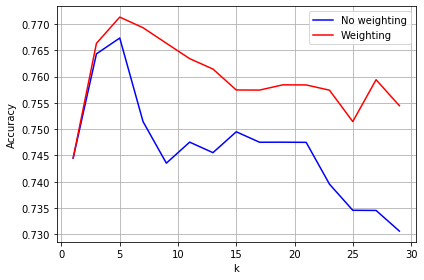

Grid search best params= {'n_neighbors': 5, 'weights': 'distance'} Accuracy= 0.7713168316831683


In [58]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [59]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[  8  25   0   0   0]
 [  5 252  14   0   0]
 [  0  39  56   6   0]
 [  0   0  11   9   0]
 [  0   0   2   3   2]]
0.7569444444444444


As we can see it clearly recognizes the second level but not the others. Especially the level 1 and 4 are quite wrong.

## 2.2 Only categorical features

In [60]:
# only categorical
X_train = train_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(X_train)
X_test = test_data.select_dtypes(include=['object','bool'])
transform_categorical_to_numerical(X_test)

### 10 cross-validation

In [61]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.76237624 0.69306931 0.59405941 0.62376238 0.64356436 0.72277228
 0.7        0.68       0.72       0.71      ]


In [62]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.6849603960396038
0.04828672268327415


### Find best parameters

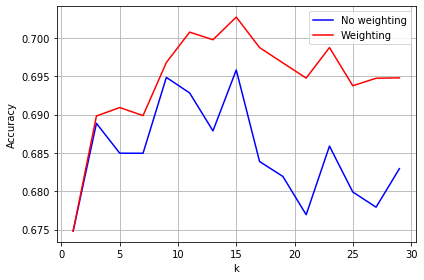

Grid search best params= {'n_neighbors': 15, 'weights': 'distance'} Accuracy= 0.7027029702970297


In [63]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [64]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[  2  31   0   0   0]
 [  2 244  25   0   0]
 [  0  53  45   3   0]
 [  0   8   5   7   0]
 [  0   3   2   2   0]]
0.6898148148148148


It has lower accuracy than the previous one. 

## 2.3 Categorical and numerical features

In [41]:
X_train = train_data
transform_categorical_to_numerical(X_train)
X_test = test_data
transform_categorical_to_numerical(X_test)

### 10 cross-validation

In [42]:
cv_scores = make_k_cross_validation(10,X_train,y_train)
print(cv_scores)

[0.77227723 0.7029703  0.61386139 0.62376238 0.65346535 0.72277228
 0.71       0.69       0.74       0.75      ]


In [43]:
# Let's get the mean of the 10 validations (and standard deviation of them)
print(np.mean(cv_scores))
print(np.std(cv_scores))

0.6979108910891089
0.05040363400538623


### Find best parameters

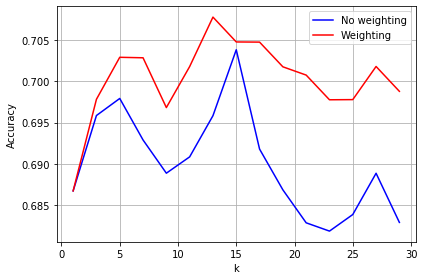

Grid search best params= {'n_neighbors': 13, 'weights': 'distance'} Accuracy= 0.7077326732673267


In [44]:
parval = find_best_params(X_train,y_train)

### See results with test data

In [45]:
accuracy_with_test_data(parval['n_neighbors'],parval['weights'],X_train,y_train,X_test,y_test)

[[  5  28   0   0   0]
 [  2 242  27   0   0]
 [  0  50  44   7   0]
 [  0   6   8   6   0]
 [  0   3   2   2   0]]
0.6875


### [Optional] Let's see how ammount of training data influences accuracy 

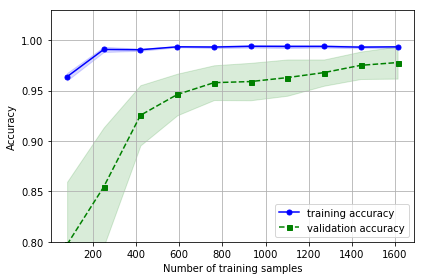

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=nb.KNeighborsClassifier(n_neighbors=3),
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=600)
plt.show()

## 5- Finding parameters for k-NN

In [19]:
# interval confidence
from statsmodels.stats.proportion import proportion_confint

epsilon = sklearn.metrics.accuracy_score(y_test, pred)
print("Can approximate by Normal Distribution?: ",X_test.shape[0]*epsilon*(1-epsilon)>5)
print("Interval 95% confidence:", "{0:.3f}".format(epsilon), "+/-", "{0:.3f}".format(1.96*np.sqrt(epsilon*(1-epsilon)/X_test.shape[0])))
# or equivalent 
proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='normal')

Can approximate by Normal Distribution?:  False
Interval 95% confidence: 0.991 +/- 0.008


(0.98266245251249873, 0.99881902896898267)

In [20]:
#Using Binomial distribution

proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')

(0.9781611871249579, 0.9963446921115061)

### Play with noise

In [25]:
# Lets' add noise to data: 64 new columns with random data
nrcols=64
col = np.random.randint(0,17,(X_train.data.shape[0],nrcols))
col

array([[12, 12, 11, ...,  1, 12,  6],
       [12,  4, 14, ...,  7,  1,  6],
       [ 0,  3,  2, ...,  4, 10, 15],
       ..., 
       [ 4,  6,  2, ...,  9, 12,  1],
       [12,  9,  6, ..., 10,  3,  3],
       [ 8,  1,  8, ...,  0,  3,  7]])

In [26]:
Xr=np.hstack((X_train,col))
Xr

array([[  0.,   0.,   2., ...,   1.,  12.,   6.],
       [  0.,   0.,   3., ...,   7.,   1.,   6.],
       [  0.,   0.,   6., ...,   4.,  10.,  15.],
       ..., 
       [  0.,   0.,   7., ...,   9.,  12.,   1.],
       [  0.,   0.,   0., ...,  10.,   3.,   3.],
       [  0.,   0.,   8., ...,   0.,   3.,   7.]])

In [27]:
col = np.random.randint(0,17,(X_test.data.shape[0],nrcols))
Xr_test=np.hstack((X_test,col))

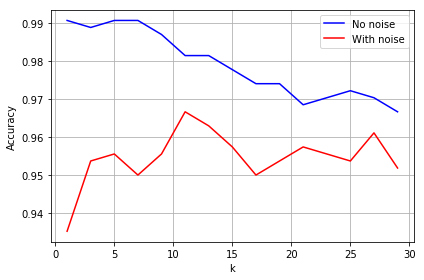

In [28]:
lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(X_train, y_train)
    lr.append(knc.score(X_test, y_test))         
plt.plot(range(1,30,2),lr,'b',label='No noise')

lr = []
for ki in range(1,30,2):
    knc = nb.KNeighborsClassifier(n_neighbors=ki)
    knc.fit(Xr, y_train)
    lr.append(knc.score(Xr_test, y_test))  
plt.plot(range(1,30,2),lr,'r',label='With noise')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.show()

### Change the scorer function

In [34]:
#Let's try to optimize parameters for precision of class "9"

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring="accuracy") 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))

print('Precision for "9": %.3f' % precision_score(y_true=y_test, y_pred=pred,average='macro',labels=[9]))

Best Params= {'n_neighbors': 3, 'weights': 'distance'} Accuracy= 0.984089101034
[[59  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 56  0  1]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        59
          1       0.98      1.00      0.99        49
          2       1.00      0.98      0.99        49
          3       1.00      1.00      1.00        64
          4       1.00      1.00      1.00        61
          5       0.98      0.98      0.98        47
          6       1.00      1.00      1.00        51
          7       0.98      0.98      0.98        57
          8       1.00      0.98      0.99        46
          9       0.97      0.98      0.97 

In [35]:
# Precison of class 9 is low compared with others. 
# Assume precision of "9" is critical. Let's change optimize parameters by defining precision for 9.

scorer = make_scorer(precision_score,average='macro',labels=[9])
#scorer = make_scorer(score_func=precision_score, pos_label=9, greater_is_better=True,average='micro')


params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1,scoring=scorer) 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Precision=", clf.best_score_)

parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_test, pred))
print(sklearn.metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))


Best Params= {'n_neighbors': 7, 'weights': 'distance'} Precision= 0.98507697553
[[58  0  0  0  1  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 57  0  0]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]
0.990740740741
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        59
          1       0.98      1.00      0.99        49
          2       1.00      0.98      0.99        49
          3       1.00      1.00      1.00        64
          4       0.98      1.00      0.99        61
          5       0.98      0.98      0.98        47
          6       1.00      1.00      1.00        51
          7       0.98      1.00      0.99        57
          8       1.00      0.98      0.99        46
          9       0.98      0.98      0.98 